### Imports, paths and config

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np

repo_root = Path.cwd().parents[0]
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from helper.utils import find_repo_root, load_pipeline_config, save_run_log, ensure_dir

repo_root = find_repo_root()
cfg = load_pipeline_config(repo_root)

processed_dir = repo_root / cfg["paths"]["processed_dir"]
results_dir = repo_root / cfg["paths"]["results_dir"]
models_dir = repo_root / cfg["paths"]["models_dir"]

ensure_dir(results_dir)
ensure_dir(models_dir)

print("processed_dir:", processed_dir)
print("results_dir:", results_dir)
print("models_dir:", models_dir)

processed_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/data/processed
results_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/data/results
models_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/notebooks/models


### Load processed splits (Train/Test/Validation)

In [3]:
import pandas as pd
from pathlib import Path

def load_split(split_dir_name: str, x_candidates: list[str], y_candidates: list[str]):
    split_dir = processed_dir / split_dir_name
    assert split_dir.exists(), f"Split folder not found: {split_dir}"

    x_path = next((split_dir / f for f in x_candidates if (split_dir / f).exists()), None)
    y_path = next((split_dir / f for f in y_candidates if (split_dir / f).exists()), None)

    if x_path is None or y_path is None:
        raise FileNotFoundError(
            f"Could not find X/y files in {split_dir}.\n"
            f"Found: {[p.name for p in split_dir.glob('*.csv')]}\n"
            f"Expected one of X: {x_candidates}\n"
            f"Expected one of y: {y_candidates}"
        )

    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path).squeeze("columns")
    return X, y, x_path.name, y_path.name

# Train
X_train, y_train, xtr, ytr = load_split(
    "Train",
    x_candidates=["X_train.csv", "BioFairNet_Pilot1_Testrun_Train_in.csv"],
    y_candidates=["y_train.csv", "BioFairNet_Pilot1_Testrun_Train_out.csv"],
)

# Test
X_test, y_test, xte, yte = load_split(
    "Test",
    x_candidates=["X_test.csv", "BioFairNet_Pilot1_Testrun_Test_in.csv"],
    y_candidates=["y_test.csv", "BioFairNet_Pilot1_Testrun_Test_out.csv"],
)

# Validation (folder might be "Validation" or you might have used "Val")
val_folder = "Validation" if (processed_dir / "Validation").exists() else "Val"
X_val, y_val, xva, yva = load_split(
    val_folder,
    x_candidates=["X_val.csv", "X_validation.csv"],
    y_candidates=["y_val.csv", "y_validation.csv"],
)

print(f"Train loaded: {xtr}, {ytr} -> {X_train.shape}")
print(f"Test  loaded: {xte}, {yte} -> {X_test.shape}")
print(f"Val   loaded: {xva}, {yva} -> {X_val.shape}")

Train loaded: X_train.csv, y_train.csv -> (5904, 3)
Test  loaded: X_test.csv, y_test.csv -> (1476, 3)
Val   loaded: X_val.csv, y_val.csv -> (1845, 3)


### Define models + grids

Reasonable defaults are chosen, which should work well in most cases.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

seed = cfg["ml"]["random_seed"]

models = {
    "linreg": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "rf": RandomForestRegressor(random_state=seed),
    "gbr": GradientBoostingRegressor(random_state=seed),
    "svr": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR())
    ]),
    "mlp": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(random_state=seed, max_iter=2000))
    ]),
}

param_grids = {
    "linreg": {},  # no hyperparameters
    "rf": {
        "n_estimators": [200, 500],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
    },
    "gbr": {
        "n_estimators": [200, 500],
        "learning_rate": [0.05, 0.1],
        "max_depth": [2, 3, 4],
    },
    "svr": {
        "model__C": [0.1, 1, 10],
        "model__epsilon": [0.01, 0.1, 0.2],
        "model__kernel": ["rbf"],
        "model__gamma": ["scale", "auto"],
    },
    "mlp": {
        "model__hidden_layer_sizes": [(50,), (100,), (100,50)],
        "model__alpha": [1e-4, 1e-3],
        "model__learning_rate_init": [1e-3, 5e-4],
    }
}

enabled = cfg["ml"].get("models_default", list(models.keys()))
models = {k: v for k, v in models.items() if k in enabled}
param_grids = {k: v for k, v in param_grids.items() if k in enabled}

print("Enabled models:", list(models.keys()))


Enabled models: ['linreg', 'rf', 'gbr', 'svr', 'mlp']


### Scoring (RMSE + R2) and GridSearchCV

We'll optimize for RMSE. In Scikit-learn, RMSE is "negative RMSE" as a scorer.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import time

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

rmse_scorer = make_scorer(
    lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)),
    greater_is_better=True
)

cv_folds = cfg["ml"]["gridsearch"]["cv_folds"]
n_jobs = cfg["ml"]["gridsearch"]["n_jobs"]

results = []
best_models = {}

for name, estimator in models.items():
    grid = param_grids.get(name, {})
    print(f"\n=== {name} ===")
    start = time.time()

    if len(grid) == 0:
        # No grid -> just fit
        estimator.fit(X_train, y_train)
        best = estimator
        best_params = {}
    else:
        gs = GridSearchCV(
            estimator=estimator,
            param_grid=grid,
            scoring=rmse_scorer,   # optimize RMSE
            cv=cv_folds,
            n_jobs=n_jobs,
            refit=True
        )
        gs.fit(X_train, y_train)
        best = gs.best_estimator_
        best_params = gs.best_params_

    # Evaluate on TEST and HOLDOUT (VAL)
    yhat_test = best.predict(X_test)
    yhat_val = best.predict(X_val)

    row = {
        "model": name,
        "rmse_test": rmse(y_test, yhat_test),
        "r2_test": float(r2_score(y_test, yhat_test)),
        "rmse_val": rmse(y_val, yhat_val),
        "r2_val": float(r2_score(y_val, yhat_val)),
        "fit_seconds": round(time.time() - start, 2),
        "best_params": best_params
    }
    results.append(row)
    best_models[name] = best

    print("Test RMSE:", row["rmse_test"], "Test R2:", row["r2_test"])
    print("Val  RMSE:", row["rmse_val"],  "Val  R2:", row["r2_val"])



=== linreg ===
Test RMSE: 1.9107115994445818 Test R2: 0.9738142519087712
Val  RMSE: 1.9352834018728544 Val  R2: 0.9747418382995199

=== rf ===
Test RMSE: 0.021830429894455893 Test R2: 0.9999965817857399
Val  RMSE: 0.024373467737265123 Val  R2: 0.9999959936651834

=== gbr ===
Test RMSE: 0.030176719191718195 Test R2: 0.9999934684125099
Val  RMSE: 0.03174256737896985 Val  R2: 0.9999932048868047

=== svr ===
Test RMSE: 0.12191607524155684 Test R2: 0.9998933903170043
Val  RMSE: 0.11422143119546141 Val  R2: 0.9999120151717406

=== mlp ===
Test RMSE: 0.11212210513857249 Test R2: 0.9999098310127479
Val  RMSE: 0.10235505096866408 Val  R2: 0.999929346911157


### Compare models and select best

Primary: lowest `rmse_val`, secondary: highest `r2_val`.

In [9]:
res_df = pd.DataFrame(results).sort_values(["rmse_val", "r2_val"], ascending=[True, False]).reset_index(drop=True)
print(res_df.head())

# Pick best:
best_name = res_df.iloc[0]["model"]
best_model = best_models[best_name]
print("✅ Best model:", best_name)

#Save comparison table:
comparison_path = results_dir / "model_comparison.csv"
res_df.to_csv(comparison_path, index=False)
print("✅ Saved:", comparison_path.relative_to(repo_root))

    model  rmse_test   r2_test  rmse_val    r2_val  fit_seconds  \
0      rf   0.021830  0.999997  0.024373  0.999996        63.27   
1     gbr   0.030177  0.999993  0.031743  0.999993        33.43   
2     mlp   0.112122  0.999910  0.102355  0.999929       132.42   
3     svr   0.121916  0.999893  0.114221  0.999912        49.22   
4  linreg   1.910712  0.973814  1.935283  0.974742         0.03   

                                         best_params  
0  {'max_depth': None, 'min_samples_split': 2, 'n...  
1  {'learning_rate': 0.05, 'max_depth': 4, 'n_est...  
2  {'model__alpha': 0.001, 'model__hidden_layer_s...  
3  {'model__C': 10, 'model__epsilon': 0.1, 'model...  
4                                                 {}  
✅ Best model: rf
✅ Saved: data/results/model_comparison.csv


### Predictions export

In [10]:
pred_test = pd.DataFrame({"y_true": y_test, "y_pred": best_model.predict(X_test)})
pred_val  = pd.DataFrame({"y_true": y_val,  "y_pred": best_model.predict(X_val)})

pred_test_path = results_dir / f"predictions_test_{best_name}.csv"
pred_val_path  = results_dir / f"predictions_val_{best_name}.csv"

pred_test.to_csv(pred_test_path, index=False)
pred_val.to_csv(pred_val_path, index=False)

print("✅ Saved:", pred_test_path.relative_to(repo_root))
print("✅ Saved:", pred_val_path.relative_to(repo_root))


✅ Saved: data/results/predictions_test_rf.csv
✅ Saved: data/results/predictions_val_rf.csv


### Scatter Plot

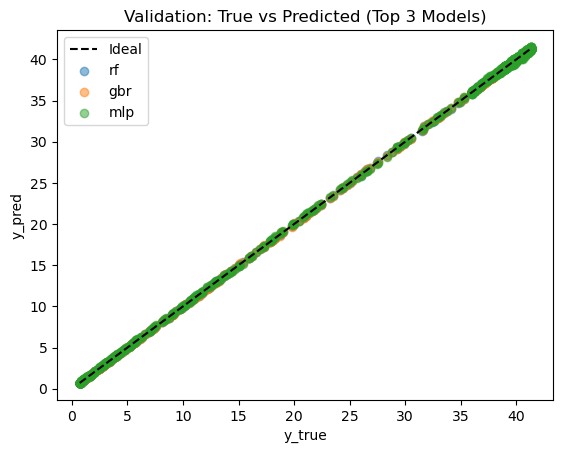

✅ Saved: data/results/val_scatter_top3.png


In [13]:
import matplotlib.pyplot as plt

top3 = res_df.head(3)["model"].tolist()

# Scatter: y_true vs y_pred for top 3 on VAL
plt.figure()
plt.title("Validation: True vs Predicted (Top 3 Models)")
plt.xlabel("y_true")
plt.ylabel("y_pred")

# Ideal line
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', label='Ideal')

for m in top3:
    ypred = best_models[m].predict(X_val)
    plt.scatter(y_val, ypred, label=m, alpha=0.5)

plt.legend()
scatter_path = results_dir / "val_scatter_top3.png"
plt.savefig(scatter_path, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", scatter_path.relative_to(repo_root))


### Bar Charts

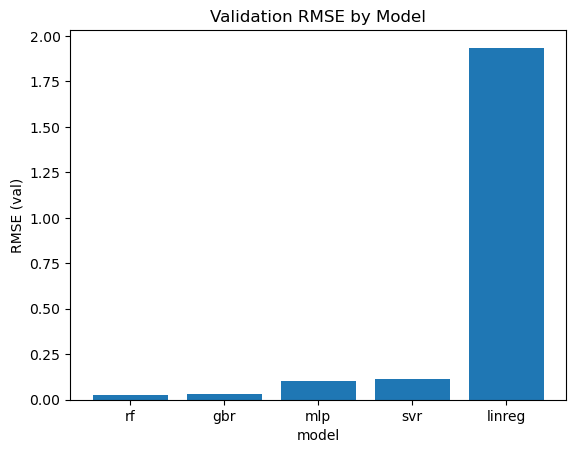

✅ Saved: data/results/val_rmse_bar.png


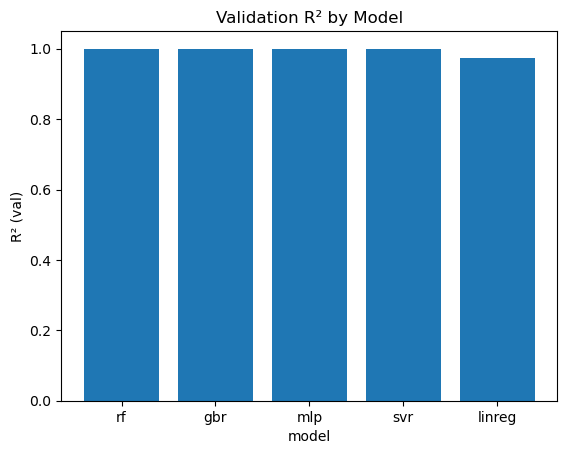

✅ Saved: data/results/val_r2_bar.png


In [14]:
# RMSE bar
plt.figure()
plt.title("Validation RMSE by Model")
plt.xlabel("model")
plt.ylabel("RMSE (val)")
plt.bar(res_df["model"], res_df["rmse_val"])
rmse_bar_path = results_dir / "val_rmse_bar.png"
plt.savefig(rmse_bar_path, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", rmse_bar_path.relative_to(repo_root))

# R2 bar
plt.figure()
plt.title("Validation R² by Model")
plt.xlabel("model")
plt.ylabel("R² (val)")
plt.bar(res_df["model"], res_df["r2_val"])
r2_bar_path = results_dir / "val_r2_bar.png"
plt.savefig(r2_bar_path, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", r2_bar_path.relative_to(repo_root))


### Save the model, the bundle and run logs

In [15]:
import pickle

bundle = {
    "best_model_name": best_name,
    "best_model": best_model,
    "all_models": best_models,
    "comparison": res_df,
    "config": cfg
}

bundle_path = models_dir / "all_models.pkl"
with open(bundle_path, "wb") as f:
    pickle.dump(bundle, f)

print("✅ Saved model bundle:", bundle_path.relative_to(repo_root))

log_path = save_run_log(
    stage="train_optimize",
    payload={
        "best_model": best_name,
        "comparison_csv": str(comparison_path.relative_to(repo_root)),
        "plots": [str(scatter_path.relative_to(repo_root)),
                  str(rmse_bar_path.relative_to(repo_root)),
                  str(r2_bar_path.relative_to(repo_root))],
        "bundle": str(bundle_path.relative_to(repo_root))
    },
    repo_root=repo_root,
    run_logs_rel_dir=cfg["paths"]["run_logs_dir"]
)

print("✅ Run log:", log_path.relative_to(repo_root))


✅ Saved model bundle: notebooks/models/all_models.pkl
✅ Run log: metadata/runs/train_optimize_20260127T124342Z.json
